# Project 2: Graph Mining
*Due Wednesday November 14th, 2018 at 11:59 pm*  
*Notebook Author: Koki Sasagawa*

Mining a large social network to uncover how well homophily can predict identity as well as the network structure. 

## Task 2:
Attribute Prediction - most of the nodes in the social network are provided with one or more attributes that can be drawn from different types. (e.g., age, occupation, musical preference, etc. ) Predict the probabilities of attributes for a set of completely unlabeled nodes

## Data
1. `labeled-vertices.train.tsv` & `labeled-vertices.dev.tsv` & `unlabeled-verticies.test.tsv` 
   - users with attributes formatted as the following: 

   > - **vertex1** T1:3 T7:1 T4:2
   > - **vertex2** T2:4
   > - **vertex3** T4:3 T3:1
   
   - Each value is specified as `AttributeType:Value`
   - Not every user will have their attributes listed 
   - Majority users should have at least 2 attribute set
2. `unlabeled-verticies.test.txt` - list of vertices that we will predict attributes and their values for

## Submission 

**Attribute prediction** should be a csv file with two columns: id and attr. 
The attr column should contain a space-deliminted list of the attributes you think the user with that id has. The file should have the following structure:

> id, attr
> 
> 123, T0:0 T1:1 

## Running the Notebook


In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import time
import matplotlib.pyplot as plt
import seaborn as sns
from decorators import timer
%matplotlib inline

## 1. Create Graph

In [2]:
print("Creating network graph...")
start_time = time.perf_counter() 

with open("../data/network.tsv", 'rb') as f:
    grph = nx.read_edgelist(path=f, delimiter='\t', encoding='utf8')

end_time = time.perf_counter() 
print("Network graph created. Process took {:.04f} seconds".format(end_time - start_time))

# Check that graph is of correct size
print("Number of edges: {}".format(grph.number_of_edges())) # There should be 30915267
print("Number of nodes: {}".format(grph.number_of_nodes())) # There should be 6626753

Creating network graph...
Network graph created. Process took 351.4198 seconds
Number of edges: 30915267
Number of nodes: 6626753


## 2. Load all files for attribute prediction 

In [2]:
@timer
def load_data(file_name):
    chunks = pd.read_csv(file_name, 
                         delimiter='\t',
                         names=['id', 'attr'],
                         header=None,
                         chunksize=100000)

    output = pd.concat(chunks)
    
    return output

In [3]:
dev_set = load_data('../data2/labeled-vertices.dev.tsv')

print('Total number of nodes: {}'.format(dev_set.shape[0]))
dev_set.head()

Running load_data...
Finished in 0.2390s
Total number of nodes: 662675


,id,attr
0,2666403,T0:2 T1:99
1,2627940,T0:0 T1:26
2,4843136,T0:0 T1:26
3,5396835,T0:0 T1:1813
4,5438188,T0:1 T1:1733


In [4]:
train_set = load_data('../data2/labeled-vertices.train.tsv')

print('Total number of nodes: {}'.format(train_set.shape[0]))
train_set.head()

Running load_data...
Finished in 1.8742s
Total number of nodes: 5301403


,id,attr
0,5509623,T0:0 T1:0
1,6334893,T0:0 T1:1
2,1218900,T0:1 T1:2
3,3871398,T0:1 T1:2
4,3942361,T0:0 T1:3


**Important Note:** The following concatenation step was left out for the kaggle submission and all predictions were made using only the train_set. This error lead to many nodes with 'empty' attributes, leading to a lower performance score. Combining the two files improved the f1 score of the Adamic/Adar + Preferential Attachment predictions from 0.78475 to 0.81436. 

In [5]:
tot_set = pd.concat([train_set, dev_set]).reset_index(drop=True)

tot_set = tot_set.drop_duplicates(keep='first')

print('Total number of nodes: {}'.format(tot_set.shape[0]))
tot_set.head()

Total number of nodes: 5964078


,id,attr
0,5509623,T0:0 T1:0
1,6334893,T0:0 T1:1
2,1218900,T0:1 T1:2
3,3871398,T0:1 T1:2
4,3942361,T0:0 T1:3


In [6]:
print('Reading in test set...')
start_time = time.time()

test_set = []

with open('../data2/unlabeled-vertices.test.txt') as f:
    for line in f:
        test_set.append(line.rstrip())

end_time = time.time()
print("Test set loaded. Process took {:.04f} seconds".format(end_time - start_time))

print('Total number of nodes: {}'.format(len(test_set)))
test_set[:5]

Reading in test set...
Test set loaded. Process took 0.2387 seconds
Total number of nodes: 662675


['4546232', '3711008', '6394112', '5883774', '2843733']

## 3. Define the functions for attribute prediction

The following function will compute some similarity metric on the neighbors of a node, and the node will inherit the attributes of the highest scoring node.

In [7]:
@timer
def highest_jaccard_similarity(test_set, grph):
    '''Calculate then jaccard similarity of neighbors and return the most similar node
    
    If jaccard similarity of two nodes is zero, return 0 
    
    :params test_set: target nodes we want to find the most similar neighbor for
    :type test_set: list of str
    :params grph: network graph containing target nodes
    :type grph: networkx.classes.graph.Graph
    :returns: node and the most similar neighboring node
    :rtype: dict of {str : str}
    '''
    
    sim_results = {}
    
    for i in test_set:
        nearest_neighbors = list(grph.neighbors(i))
        # Make sure that node has neighbors
        if nearest_neighbors:
            # If a node only has only 1 neighbor, inherit that neighbors attributes 
            if len(nearest_neighbors) == 1: 
                sim_results[i] = nearest_neighbors[0]
            else:
                # Generate node-neighbor pairings 
                node_pairs = [(i, j) for j in nearest_neighbors]
                preds = nx.jaccard_coefficient(grph, ebunch=node_pairs)

                # Sort by similarity score
                preds = list(preds)
                preds.sort(key=lambda x: x[2], reverse=True)

                # Take the node with highest sim score
                # If similarity is 0, return 0
                if preds[0][2] == 0:
                    sim_results[i] = 0
                else:
                    sim_results[i] = preds[0][1]
        else: 
            sim_results[i] = 0

    return sim_results

In [8]:
def highest_adamic_adar_similarity(test_set, grph):
    '''Calculate then adamic/adar similarity of neighbors and return the most similar node
    
    If adamic/adar similarity of two nodes is zero, return 0
    
    :params test_set: target nodes we want to find the most similar neighbor for
    :type test_set: list of str
    :params grph: network containing target nodes
    :type grph: networkx.classes.graph.Graph
    :returns: node and the most similar neighboring node
    :rtype: dict of {str : str}
    '''
    
    sim_results = {}
    
    for i in test_set:
        nearest_neighbors = list(grph.neighbors(i))
        # Make sure that node has neighbors
        if nearest_neighbors:
            # If a node only has only 1 neighbor, inherit that neighbors attributes 
            if len(nearest_neighbors) == 1: 
                sim_results[i] = nearest_neighbors[0]
            else:
                # Generate node-neighbor pairings 
                node_pairs = [(i, j) for j in nearest_neighbors]
                preds = nx.adamic_adar_index(grph, ebunch=node_pairs)

                # Sort by similarity score
                preds = list(preds)
                preds.sort(key=lambda x: x[2], reverse=True)

                # Take the node with highest sim score
                # If similarity is 0, return 0
                if preds[0][2] == 0:
                    sim_results[i] = 0
                else:
                    sim_results[i] = preds[0][1]
        else:
            sim_results[i] = 0

    return sim_results

In [9]:
def highest_preferential_attachment_score(test_set, grph):
    '''Calculate then preferential attachment scores of neighbors and return the highest scoring node
    
    :params test_set: target nodes we want to find the most similar neighbor for
    :type test_set: list of str
    :params grph: network containing target nodes
    :type grph: networkx.classes.graph.Graph
    :returns: node and the most similar neighboring node
    :rtype: dict of {str : str}
    '''
    
    sim_results = {}
    
    for i in test_set:
        nearest_neighbors = list(grph.neighbors(i))
        # Make sure that node has neighbors
        if nearest_neighbors:
            # If a node only has only 1 neighbor, inherit that neighbors attributes 
            if len(nearest_neighbors) == 1: 
                sim_results[i] = nearest_neighbors[0]
            else:
                # Generate node-neighbor pairings 
                node_pairs = [(i, j) for j in nearest_neighbors]
                preds = nx.preferential_attachment(grph, ebunch=node_pairs)

                # Sort by score
                preds = list(preds)
                preds.sort(key=lambda x: x[2], reverse=True)

                # Take the node with highest score
                # If score is 0, return 0
                if preds[0][2] == 0:
                    sim_results[i] = 0
                else:
                    sim_results[i] = preds[0][1]
        else:
            sim_results[i] = 0

    return sim_results

# 4. Generate node pairs

Jaccard similarity and Adamic/Adar similarity both require nodes to have common neighbors, or the similarity score will be zero. Preferential attachment, however, can still be calculated as it is based on the idea that nodes will attach to nodes of higher degree. For nodes where Jaccard and Adamic/Adar failed to produce a similarity score, use the node suggested by rules of preferential attachment. 

## 4.a. Jaccard Similarity

In [10]:
print('Running jaccard similarity...')
start_time = time.time()

jaccard_similarity_nodes = highest_jaccard_similarity(test_set, grph)

end_time = time.time()
print("Node pairs generated. Process took {:.04f} seconds".format(end_time - start_time))

Running jaccard similarity...
Node pairs generated. Process took 21.4838 seconds


## 4.b. Adamic/Adar Similarity

In [11]:
print('Running adamic/adar similarity...')
start_time = time.time()

adamic_adar_nodes = highest_adamic_adar_similarity(test_set, grph)

end_time = time.time()
print("Node pairs generated. Process took {:.04f} seconds".format(end_time - start_time))

Running adamic/adar similarity...
Node pairs generated. Process took 3.9662 seconds


## 4.c. Preferential Attachment

In [12]:
print('Running preferential attachment...')
start_time = time.time()

preferential_attachment_nodes = highest_preferential_attachment_score(test_set, grph)

end_time = time.time()
print("Node pairs generated. Process took {:.04f} seconds".format(end_time - start_time))

Running preferential attachment...
Node pairs generated. Process took 2.5593 seconds


# 5. Select between Jaccard similarity, Adamic/Adar, or preferential attachment node pairs for attribute predictions 

## Round 1. Jaccard

In [13]:
# predictions = pd.DataFrame({
#                         'id': test_set,
#                         'jaccard_similarity': list(jaccard_similarity_nodes.values())
#                         })

## Round 2. Jaccard + Preferential Attachment

In [14]:
# predictions = pd.DataFrame({
#                         'id': test_set,
#                         'jaccard_similarity': list(jaccard_similarity_nodes.values()), 
#                         'preferential_attachment': list(preferential_attachment_nodes.values()),
#                         })

## Round 3. Adamic/Adar 

In [15]:
# predictions = pd.DataFrame({
#                         'id': test_set,
#                         'adamic_adar': list(adamic_adar_nodes.values())
#                         })

## Round 4. Adamic/Adar + Preferential Attachment

In [16]:
predictions = pd.DataFrame({
                        'id': test_set,
                        'adamic_adar': list(adamic_adar_nodes.values()), 
                        'preferential_attachment': list(preferential_attachment_nodes.values()),
                        })

# Free Memory 
preferential_attachment_nodes = None
adamic_adar_nodes = None

In [17]:
predictions.head()

,id,adamic_adar,preferential_attachment
0,4546232,2494614,2494614
1,3711008,2444912,2174169
2,6394112,6223074,6223074
3,5883774,4485305,4485305
4,2843733,3931905,3931905


## Rename column if only using predictions just from Jacccard or Adamic/Adar

In [18]:
# # Rename column name 
# predictions.columns = ['id','attr']

## Combine predictions from Jaccard and preferential attachment

In [19]:
# # Find the number of cells where jaccard similarity did not return a similarity score
# print("Number of 0\'s: {}".format(predictions.shape[0] - np.count_nonzero(predictions['jaccard_similarity'])))

In [20]:
# # For every row where jaccard similarity failed to return a candidate node,
# # use the node returned by preferential attachment
# predictions['attr'] = np.where(predictions['jaccard_similarity'] == 0, predictions['preferential_attachment'], predictions['jaccard_similarity'])
# print("Number of 0\'s: {}".format(predictions.shape[0] - np.count_nonzero(predictions['attr'])))

# # Drop columns we no longer need 
# predictions.drop(['jaccard_similarity', 'preferential_attachment'], axis=1, inplace=True)

## Combine predictions from Adamic/Adar and preferential attachment

In [21]:
# Find the number of cells where Adamic/Adar similarity did not return a similarity score
print("Number of 0\'s: {}".format(predictions.shape[0] - np.count_nonzero(predictions['adamic_adar'])))

Number of 0's: 58932


In [22]:
# For every row where Adamic/Adar similarity failed to return a candidate node,
# use the node returned by preferential attachment
predictions['attr'] = np.where(predictions['adamic_adar'] == 0, predictions['preferential_attachment'], predictions['adamic_adar'])
print("Number of 0\'s: {}".format(predictions.shape[0] - np.count_nonzero(predictions['attr'])))

# Drop columns we no longer need 
predictions.drop(['adamic_adar', 'preferential_attachment'], axis=1, inplace=True)

Number of 0's: 0


# 6. Obtain attributes for nodes

In [23]:
print("There are {} rows in the prediction dataframe".format(predictions.shape[0]))
predictions.head()

There are 662675 rows in the prediction dataframe


,id,attr
0,4546232,2494614
1,3711008,2444912
2,6394112,6223074
3,5883774,4485305
4,2843733,3931905


In [24]:
# Check dtype
print('dtype of id in tot_set is {}'.format(type(tot_set['id'][0])))
print('dtype of id in predictions is {}'.format(type(predictions['attr'][0])))

dtype of id in tot_set is <class 'numpy.int64'>
dtype of id in predictions is <class 'str'>


In [25]:
# The values in the prediction dataframe are currently str type
# convert them to int64 to allow merge with tot_set
predictions = predictions.astype(dtype=np.int64, copy=True)
print('dtype of id in predictions is {}'.format(type(predictions['attr'][0])))

dtype of id in predictions is <class 'numpy.int64'>


In [26]:
# Merge preditions with tot_set by id 
results = predictions.merge(tot_set, left_on='attr', right_on='id', how='left')
results.head()

,id_x,attr_x,id_y,attr_y
0,4546232,2494614,2494614.0,T0:0 T1:1766
1,3711008,2444912,2444912.0,T0:0 T1:1762
2,6394112,6223074,6223074.0,T0:0 T1:1914 T8:0
3,5883774,4485305,4485305.0,T0:0 T1:944
4,2843733,3931905,3931905.0,T0:0 T1:538


In [27]:
# Check for nan 
print('nan values:\n{}'.format(results.isna().sum()))

nan values:
id_x          0
attr_x        0
id_y      32765
attr_y    32765
dtype: int64


There are 32765 nodes that we do not know attributes for. Our current method is unable to predict attributes for these nodes. 

In [28]:
# Drop unecessary columns
results.drop(['attr_x', 'id_y'], inplace=True, axis=1)

# Rename columns
results.columns = ['id', 'attr']

# Check
results.head()

,id,attr
0,4546232,T0:0 T1:1766
1,3711008,T0:0 T1:1762
2,6394112,T0:0 T1:1914 T8:0
3,5883774,T0:0 T1:944
4,2843733,T0:0 T1:538


In [31]:
# Check
print('Results contain {} nodes'.format(results.shape[0]))

Results contain 662675 nodes


# 7. Save attribute predictions as csv file

In [32]:
# Save Results
results.to_csv('../data2/attribute_predictions.csv', index=False)
print('*****Done*****')

*****Done*****


# 8. Development Testing

Run tests using the development data to evaluate where the algorithm has weak performance. 

## Generate predictions 

In [135]:
# Change id's to str dtype to use as query for graph 
dev_set['id'] = dev_set['id'].astype(str)

In [136]:
print('Running preferential attachment...')
start_time = time.time()

preferential_attachment_nodes = highest_preferential_attachment_score(dev_set['id'], grph)

end_time = time.time()
print("Node pairs generated. Process took {:.04f} seconds".format(end_time - start_time))

Running preferential attachment...
Node pairs generated. Process took 25.2701 seconds


In [137]:
print('Running adamic/adar similarity...')
start_time = time.time()

adamic_adar_nodes = highest_adamic_adar_similarity(dev_set['id'], grph)

end_time = time.time()
print("Node pairs generated. Process took {:.04f} seconds".format(end_time - start_time))

Running adamic/adar similarity...
Node pairs generated. Process took 13.5831 seconds


In [138]:
# Predictions with Adamic/Adar + preferential attachment
predictions = pd.DataFrame({
                        'id': dev_set['id'],
                        'adamic_adar': list(adamic_adar_nodes.values()), 
                        'preferential_attachment': list(preferential_attachment_nodes.values()),
                        })

# Free Memory 
preferential_attachment_nodes = None
adamic_adar_nodes = None

In [139]:
# Find the number of cells where Adamic/Adar similarity did not return a similarity score
print("Number of 0\'s: {}".format(predictions.shape[0] - np.count_nonzero(predictions['adamic_adar'])))

Number of 0's: 140181


In [140]:
# For every row where Adamic/Adar similarity failed to return a candidate node,
# use the node returned by preferential attachment
predictions['attr'] = np.where(predictions['adamic_adar'] == 0, predictions['preferential_attachment'], predictions['adamic_adar'])
print("Number of 0\'s: {}".format(predictions.shape[0] - np.count_nonzero(predictions['attr'])))

# Drop columns we no longer need 
predictions.drop(['adamic_adar', 'preferential_attachment'], axis=1, inplace=True)

Number of 0's: 0


In [141]:
print('Predictions table have {} rows'.format(predictions.shape[0]))
predictions.head()

Predictions table have 662675 rows


,id,attr
0,2666403,2051632
1,2627940,4843136
2,4843136,2627940
3,5396835,2352112
4,5438188,5690565


## Combine predicted attributes with true attributes

In [142]:
# Check dtype
print('dtype of id in predictions is {}'.format(type(predictions['attr'][0])))

dtype of id in predictions is <class 'str'>


In [143]:
# Convert dtype to int64 to merge with train_set
predictions = predictions.astype(dtype=np.int64, copy=True)
print('dtype of id in predictions is {}'.format(type(predictions['attr'][0])))

dtype of id in predictions is <class 'numpy.int64'>


In [144]:
# Merge preditions with trainset by id 
results = predictions.merge(train_set, left_on='attr', right_on='id', how='left')

# Check
print('Results table has {} rows'.format(results.shape[0]))
results.head()

Results table has 662675 rows


,id_x,attr_x,id_y,attr_y
0,2666403,2051632,2051632.0,T0:2 T1:99
1,2627940,4843136,NaN,NaN
2,4843136,2627940,NaN,NaN
3,5396835,2352112,2352112.0,T0:0 T1:1813
4,5438188,5690565,5690565.0,T0:1 T1:1733


In [145]:
# Check for nan 
print('{} nan values'.format(results.isna().sum()))

id_x          0
attr_x        0
id_y      45764
attr_y    45764
dtype: int64 nan values


In the train set, there are 45764 nodes that do not exist. For these nodes, we can't predict their attributes so drop these rows.

In [146]:
results.dropna(inplace=True)

In [147]:
# Drop unecessary columns
results.drop(['attr_x', 'id_y'], inplace=True, axis=1)

# Rename columns
results.columns = ['id', 'predictions']

# Check
print('Results table has {} rows'.format(results.shape[0]))
results.head()

Results table has 616911 rows


,id,predictions
0,2666403,T0:2 T1:99
3,5396835,T0:0 T1:1813
4,5438188,T0:1 T1:1733
5,1394998,T0:0 T1:20
6,174985,T0:0 T1:87


In [148]:
# Check dtype
print('dtype of id in dev_set is {}'.format(type(dev_set['id'][0])))

dtype of id in dev_set is <class 'str'>


In [149]:
# Convert dtype to int64 to merge with results
dev_set['id'] = dev_set['id'].astype(np.int64)

In [150]:
# Perform a merge with indicator on
dev_results = results.merge(dev_set, left_on='id', right_on='id', how='left')
dev_results.head()

,id,predictions,attr
0,2666403,T0:2 T1:99,T0:2 T1:99
1,5396835,T0:0 T1:1813,T0:0 T1:1813
2,5438188,T0:1 T1:1733,T0:1 T1:1733
3,1394998,T0:0 T1:20,T0:0 T1:653
4,174985,T0:0 T1:87,T0:0 T1:87


In [151]:
# Rename columm
dev_results.rename(columns={'attr': 'true'}, inplace=True)

In [152]:
# If attributes are equal, assign True, else False
dev_results = dev_results.assign(NE = dev_results['true'] == dev_results['predictions'])
dev_results.head()

,id,predictions,true,NE
0,2666403,T0:2 T1:99,T0:2 T1:99,True
1,5396835,T0:0 T1:1813,T0:0 T1:1813,True
2,5438188,T0:1 T1:1733,T0:1 T1:1733,True
3,1394998,T0:0 T1:20,T0:0 T1:653,False
4,174985,T0:0 T1:87,T0:0 T1:87,True


In [153]:
# Performance results
true_pred = dev_results[dev_results['NE'] == True]
false_pred = dev_results[dev_results['NE'] == False]

print('Prediction results\n')
print('Correct predictions: {}'.format(true_pred.shape[0]))
print('Wrong predictions: {}'.format(false_pred.shape[0]))
print('Proportion correct: {:.2f}'.format((true_pred.shape[0] / dev_results.shape[0]) * 100))

Prediction results

Correct predictions: 390889
Wrong predictions: 226022
Proportion correct: 63.36


The performance is around 63.36%. The Adamic/Adar index and preferential attachment both rely on shared links between nodes. Perhaps, the poor performance is due to nodes with low connectivity.

## Plot the ave degree of nodes for wrongly and correctly predicted attribute sets 

In [72]:
print('Calculating degrees for nodes with wrong attribute predictions...')
start_time = time.time()

node_degrees = []
    
# Get degree of each node with wrong predictions 
for i in false_pred.itertuples():
    node_degrees.append(grph.degree[str(i[1])])     

end_time = time.time()
print("Degrees calculated. Process took {:.04f} seconds".format(end_time - start_time))

Calculating degrees for nodes with wrong attribute predictions...
Degrees calculated. Process took 1.8996 seconds


In [73]:
# Assign degrees to dataframe
false_pred = false_pred.assign(degree=node_degrees)

# Check
false_pred.head()

,id,true,predictions,NE,degree
3,1394998,T0:0 T1:653,T0:0 T1:20,False,2
5,3627071,T0:0 T1:119,T0:0 T1:1680,False,2
10,459751,T0:0 T1:1648,T0:0 T1:1391,False,4
13,3393434,T0:0 T1:883,T0:0 T1:883 T8:1,False,4
16,906436,T0:0 T1:1330,T0:0 T1:1299,False,1


In [74]:
print('Calculating degrees for nodes with correct attribute predictions...')
start_time = time.time()

node_degrees = []
    
# Get degree of each node with wrong predictions 
for i in true_pred.itertuples():
    node_degrees.append(grph.degree[str(i[1])])     

end_time = time.time()
print("Degrees calculated. Process took {:.04f} seconds".format(end_time - start_time))

Calculating degrees for nodes with correct attribute predictions...
Degrees calculated. Process took 2.2487 seconds


In [76]:
# Assign degrees to dataframe
true_pred = true_pred.assign(degree=node_degrees)

# Check
true_pred.head()

,id,true,predictions,NE,degree
0,2666403,T0:2 T1:99,T0:2 T1:99,True,1
1,5396835,T0:0 T1:1813,T0:0 T1:1813,True,1
2,5438188,T0:1 T1:1733,T0:1 T1:1733,True,1
4,174985,T0:0 T1:87,T0:0 T1:87,True,1
6,4073409,T0:0 T1:83,T0:0 T1:83,True,1


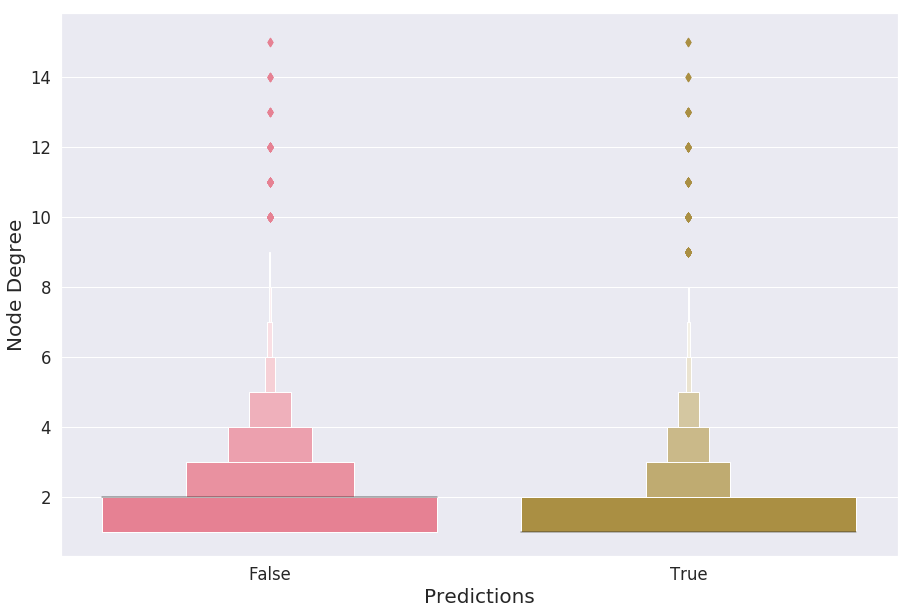

In [84]:
# Prepare data
plot_data = pd.concat([true_pred, false_pred]).reset_index(drop=True)

# Configure plot style 
sns.set(style='darkgrid', palette='husl', font_scale=1.5)
plt.figure(figsize=(15,10))

# Create plot
g = sns.boxenplot(x='NE', y='degree', data=plot_data)

# Add plot labels 
g.set_title('', fontsize=30)
g.set_xlabel('Predictions', fontsize=20)
g.set_ylabel('Node Degree', fontsize=20)

plt.show(g)

# Save File
fig = g.get_figure()
fig.savefig('./Images/{}.png'.format('ave_degree_boxenplot'))

From the boxenplot, we see that both predictions have outlier nodes with many neighbors. Although the two look similar, nodes with wrong predictions seem to have a slight larger distribution of node with greater degrees than correct predictions. 

In [105]:
# Average degree value
mean_true = np.mean(true_pred.degree)
mean_false = np.mean(false_pred.degree)
print('Average node degree of correct predictions: {:.4f}'.format(mean_true))
print('Average node degree of wrong predictions: {:.4f}'.format(mean_false))

Average node degree of correct predictions: 1.4719
Average node degree of wrong predictions: 1.8932


Calculating the mean of degrees, we see that wrong predictions have a slightly larger value of 1.8932

Evaluating the performance on the development data, we see that the average degree for nodes with wrong predictions and correct predictions are not that different. In both, majority of nodes have low degrees suggesting that they are from sparse areas of the network. Due to the lack of distinction in node connectivity between the two groups, similarity measures relying on shared neighboring nodes may not be an effective method for predicting node attributes. 

# 9. How well does homophily hold? 

Homophiliy refers to the tendency for people to have ties with people who are similar to themselves in socially significant ways. (http://www.analytictech.com/mgt780/topics/homophily.htm)

Does homophily hold well with this particular dataset?
1. Create a subgraph of the original graph and see how similar attributes are between nodes that are linked together.  

## Create a random subgraph to analyze

In [125]:
# Choose a random node, get all neighbors. 
sub_nodes = list(grph.neighbors('6334893'))

# Re-add node '6334893' as it is not part of the list sub_nodes
sub_nodes.append('6334893')

small_graph = grph.subgraph(sub_nodes)

print("Number of edges: {}".format(small_graph.number_of_edges())) 
print("Number of nodes: {}".format(small_graph.number_of_nodes()))

Number of edges: 515
Number of nodes: 72


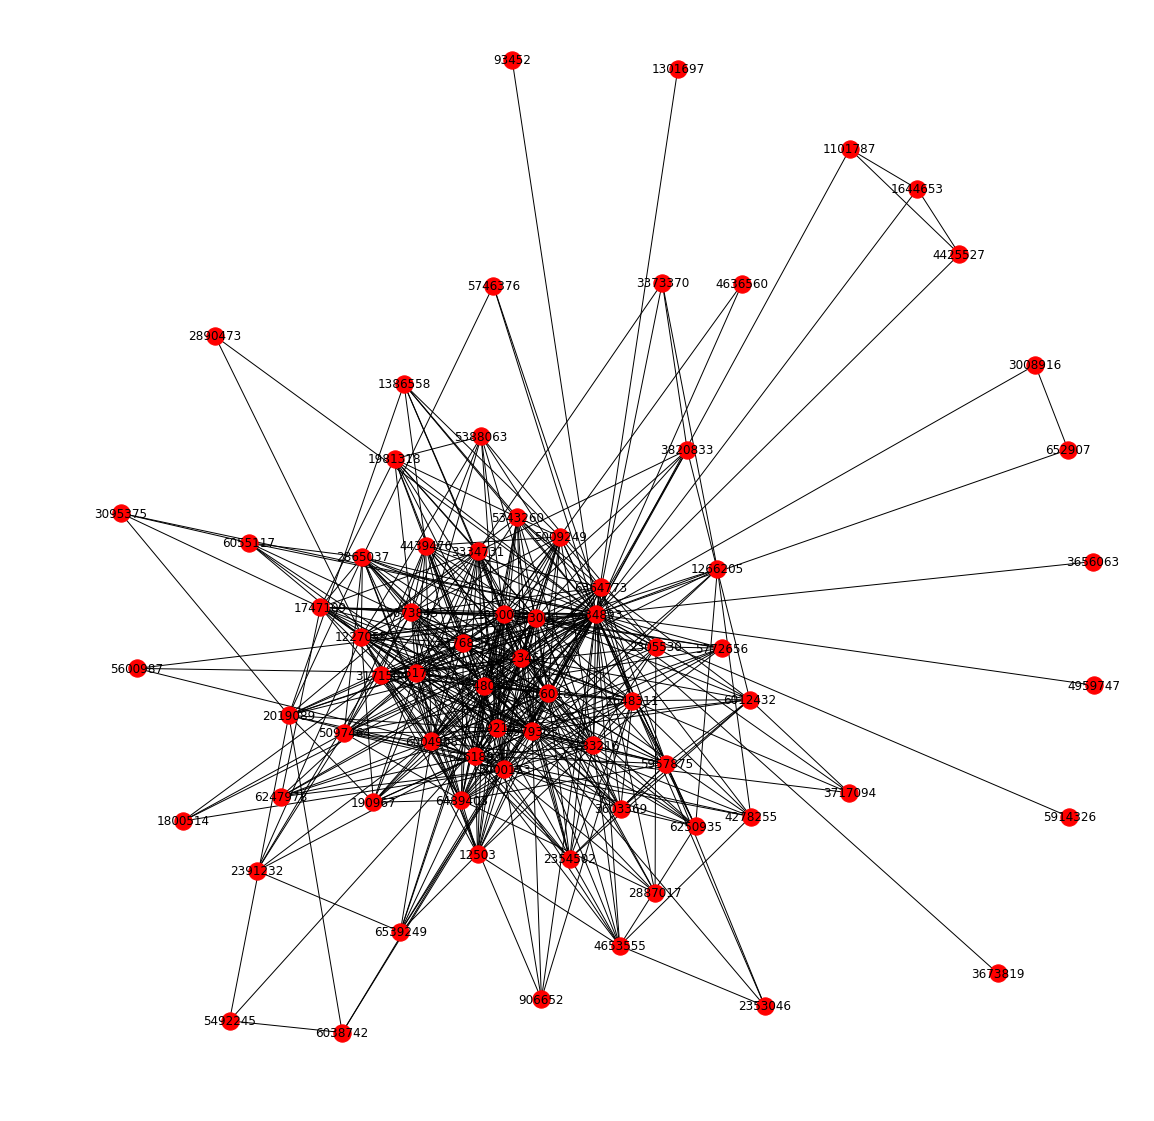

In [127]:
# Draw subgraph
plt.figure(figsize=(15,15))
nx.draw(small_graph, with_labels=True)

In [199]:
all_nodes = pd.DataFrame({'nodes': small_graph.nodes()})
all_nodes.head(3)

,nodes
0,906652
1,5009249
2,12503


In [200]:
# Convert dtype for merge 
all_nodes.nodes = all_nodes.nodes.astype(np.int64)

# Get all attribute for nodes in subgraph 
all_nodes = all_nodes.merge(tot_set, left_on='nodes', right_on='id', how='left')

# Check
all_nodes.head(3)

,nodes,id,attr
0,906652,906652.0,T0:0 T1:1
1,5009249,5009249.0,T0:0 T1:3237 T8:3
2,12503,12503.0,T0:0 T1:1872


In [201]:
# Check for rows with nan 
print('{} nan values'.format(all_nodes.isna().sum()))

nodes    0
id       1
attr     1
dtype: int64 nan values


We see that both id and attr column are nan. We do not know the attributes for this paritcular node, so remove this node. 

In [202]:
all_nodes.dropna(inplace=True)

In [203]:
# Drop unecessary columns
all_nodes.drop(['id'], inplace=True, axis=1)

## Check the distribution of attributes among nodes in subgraph

In [204]:
# Count attribute classes
attr_type_count = {}
    
for row in all_nodes.itertuples():
    if row[2]:
        # Split attribute by class and value
        for i in row[2].split():
            attr, val = i.split(':')
            attr_type_count[attr] = attr_type_count.get(attr, 0) + 1

In [205]:
for k, v in attr_type_count.items():
    print('{}/{} or {:.2f}% of nodes in the graph have attribute of class {}'.format(v, all_nodes.shape[0], (v/all_nodes.shape[0])*100,  k))

71/71 or 100.00% of nodes in the graph have attribute of class T0
71/71 or 100.00% of nodes in the graph have attribute of class T1
9/71 or 12.68% of nodes in the graph have attribute of class T8


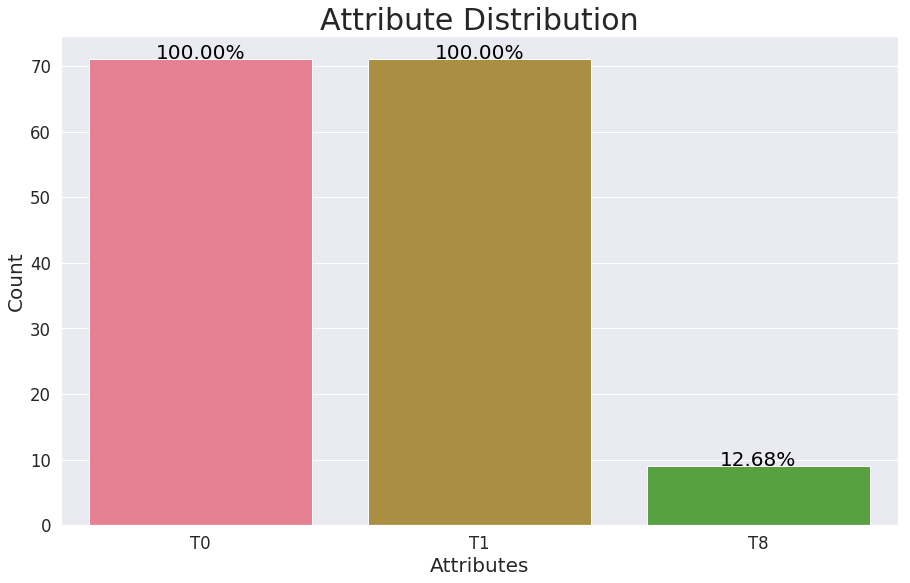

In [206]:
# Data preparation
plot_data = pd.DataFrame({'Attributes': list(attr_type_count.keys()),
                                  'Count': list(attr_type_count.values())
                                 })

# Configure plot style 
sns.set(style='darkgrid', palette='husl', font_scale=1.5)
plt.figure(figsize=(15,9))

# Create plot
g = sns.barplot(x='Attributes', y='Count', data=plot_data)

# Add plot labels 
g.set_xlabel('Attributes', fontsize=20)
g.set_ylabel('Count', fontsize=20)
g.axes.set_title('Attribute Distribution', fontsize=30)
for i in attr_distribution.itertuples():
    g.text(x=i[0], y=i[2],  
           s='{:.2f}%'.format((i[2] / all_nodes.shape[0])*100), color='black', ha="center", size=20)

# Display
plt.show(g)

# Save File
fig = g.get_figure()
fig.savefig('./Images/{}.png'.format('Attribute_Distribution_of_Subgraph'))

All nodes in ths subgraph have T0 and T1 class attributes, while signficantly less nodes (12.68%) have T8 class attributes. 

## Check the amount of varieties per attribute class

In [207]:
# Count attribute classes
variation_by_class = {'T0': [],
                      'T1': [],
                      'T8': []}
    
for row in all_nodes.itertuples():
    if row[2]:
        # Split attribute by class and value
        for i in row[2].split():
            attr, val = i.split(':')
            variation_by_class[attr].append(val)

In [208]:
# Variety frequency per attribute class
for k in variation_by_class.keys():
    unique, counts = np.unique(variation_by_class[k], return_counts=True)
    print('Attribute class {} varieties:\n{}'.format(k, unique))
    print('Frequency:\n{}'.format(counts))

Attribute class T0 varieties:
['0' '1']
Frequency:
[70  1]
Attribute class T1 varieties:
['0' '1' '1005' '1041' '1134' '1317' '182' '183' '1872' '1968' '24' '250'
 '3237' '34' '38' '437' '465' '505' '533' '595' '60' '70' '722' '73' '734'
 '801' '92']
Frequency:
[ 1 39  1  3  1  1  1  1  1  1  1  1  1  2  1  1  1  3  1  1  1  2  1  1
  1  1  1]
Attribute class T8 varieties:
['0' '1' '2' '3']
Frequency:
[1 3 2 3]


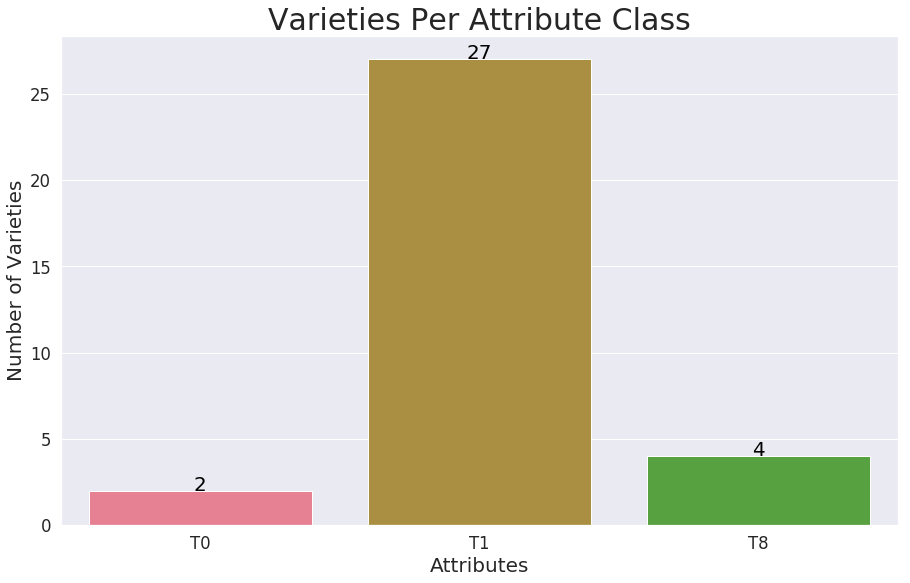

In [209]:
# Data preparation
plot_data = pd.DataFrame({'Attribute_class': list(variation_by_class.keys()),
                          'Count': [len(np.unique(variation_by_class[x])) for x in variation_by_class.keys()]})

# Configure plot style 
sns.set(style='darkgrid', palette='husl', font_scale=1.5)
plt.figure(figsize=(15,9))

# Create plot
g = sns.barplot(x='Attribute_class', y='Count', data=plot_data)

# Add plot labels 
g.set_xlabel('Attributes', fontsize=20)
g.set_ylabel('Number of Varieties', fontsize=20)
g.axes.set_title('Varieties Per Attribute Class', fontsize=30)
for i in plot_data.itertuples():
    g.text(x=i[0], y=i[2],  
           s='{}'.format(i[2]), color='black', ha="center", size=20)

# Display
plt.show(g)

# Save File
fig = g.get_figure()
fig.savefig('./Images/{}.png'.format('Varieties_Per_Attribute_Class'))

In [210]:
node_1 = []
node_2 = []

for i in list(small_graph.edges()):
    # Separate tuple into two lists: node and the node its linked with
    node_1.append(i[0])
    node_2.append(i[1])

homophily_test = pd.DataFrame({
                        'n': node_1,
                        'v': node_2
                        })

homophily_test.head()

,n,v
0,906652,6334893
1,906652,1992159
2,906652,1648311
3,906652,6579303
4,906652,6004908


In [211]:
# Convert 'n' and 'v' columns to int64 to match tot_set
homophily_test = homophily_test.astype(np.int64)

In [212]:
# Merge homphily_test dataframe with corresponding attributes to see if they overlap 
homophily_test = homophily_test.merge(tot_set, left_on='n', right_on='id', how='left')
homophily_test = homophily_test.merge(tot_set, left_on='v', right_on='id', how='left')
homophily_test.head()

,n,v,id_x,attr_x,id_y,attr_y
0,906652,6334893,906652.0,T0:0 T1:1,6334893,T0:0 T1:1
1,906652,1992159,906652.0,T0:0 T1:1,1992159,T0:0 T1:1134
2,906652,1648311,906652.0,T0:0 T1:1,1648311,T0:0 T1:1
3,906652,6579303,906652.0,T0:0 T1:1,6579303,T0:0 T1:60 T8:0
4,906652,6004908,906652.0,T0:0 T1:1,6004908,T0:0 T1:1


In [213]:
homophily_test.drop(['id_x', 'id_y'], inplace=True, axis=1)
homophily_test.columns = ['n', 'v', 'attr_n', 'attr_v']
homophily_test.head()

,n,v,attr_n,attr_v
0,906652,6334893,T0:0 T1:1,T0:0 T1:1
1,906652,1992159,T0:0 T1:1,T0:0 T1:1134
2,906652,1648311,T0:0 T1:1,T0:0 T1:1
3,906652,6579303,T0:0 T1:1,T0:0 T1:60 T8:0
4,906652,6004908,T0:0 T1:1,T0:0 T1:1


In [214]:
# Check for rows with nan 
print('{} nan values'.format(homophily_test.isna().sum()))

n         0
v         0
attr_n    1
attr_v    0
dtype: int64 nan values


In [227]:
homophily_test.dropna(inplace=True)

In [228]:
# Find where attributes are the same or different
homophily_test = homophily_test.assign(NE=homophily_test['attr_n'] == homophily_test['attr_v'])
homophily_test.head()

,n,v,attr_n,attr_v,NE
0,906652,6334893,T0:0 T1:1,T0:0 T1:1,True
1,906652,1992159,T0:0 T1:1,T0:0 T1:1134,False
2,906652,1648311,T0:0 T1:1,T0:0 T1:1,True
3,906652,6579303,T0:0 T1:1,T0:0 T1:60 T8:0,False
4,906652,6004908,T0:0 T1:1,T0:0 T1:1,True


In [229]:
print("{:.4f}% of linked node pairs share the same attribute".format((homophily_test['NE'].value_counts()[1] / homophily_test.shape[0]) * 100))
print("{:.4f}% of linked node pairs do not share the same attribute".format((homophily_test['NE'].value_counts()[0] / homophily_test.shape[0]) * 100))

34.4358% of linked node pairs share the same attribute
65.5642% of linked node pairs do not share the same attribute


In [230]:
diff_attr = homophily_test[homophily_test.NE == False]
same_attr = homophily_test[homophily_test.NE == True]

In [252]:
# Find instances when paired nodes have different attributes 
all_pair_difference = []
    
for row in diff_attr.itertuples():
    # Store attribute for comparison 
    node_attr = {}
    
    # First node attributes
    for i in row[3].split():
        attr, val = i.split(':')
        node_attr[attr] = val 
    
    # Store pair difference 
    difference = list(node_attr.keys())
    
    # Second node attributes
    for j in row[4].split():
        attr, val = j.split(':')
        # Check if attribute class was present in first node, then compare values 
        if attr in difference:
            if val == node_attr[attr]:
                difference.remove(attr)
        else:
            difference.append(attr)
    
    # Store difference between pair
    all_pair_difference.append(difference)

In [253]:
print('Difference between pairs:')
all_pair_difference = [x for x in all_pair_difference]
all_pair_difference = pd.DataFrame({'attributes': all_pair_difference})
all_pair_difference.attributes.value_counts()

Difference between pairs:


[T1]        160
[T1, T8]    118
[T8]         58
[T0, T1]      1
Name: attributes, dtype: int64

In [ ]:
# Configure plot style 
sns.set(style='darkgrid', palette='husl', font_scale=1.5)
plt.figure(figsize=(15,9))

# Create plot
g = sns.barplot(x='Attributes', y='Count', data=attr_distribution)

# Add plot labels 
g.set_xlabel('Attributes', fontsize=20)
g.set_ylabel('Count', fontsize=20)
g.axes.set_title('Attribute Distribution', fontsize=30)
for i in all_pair_difference.itertuples():
    g.text(x=i[0], y=i[2],  
           s='{:.2f}%'.format((i[2] / diff_attr.shape[0])*100), color='black', ha="center", size=20)

# Display
plt.show(g)

# Save File
fig = g.get_figure()
fig.savefig('./{}.png'.format('Attribute_Distribution_of_Subgraph'))

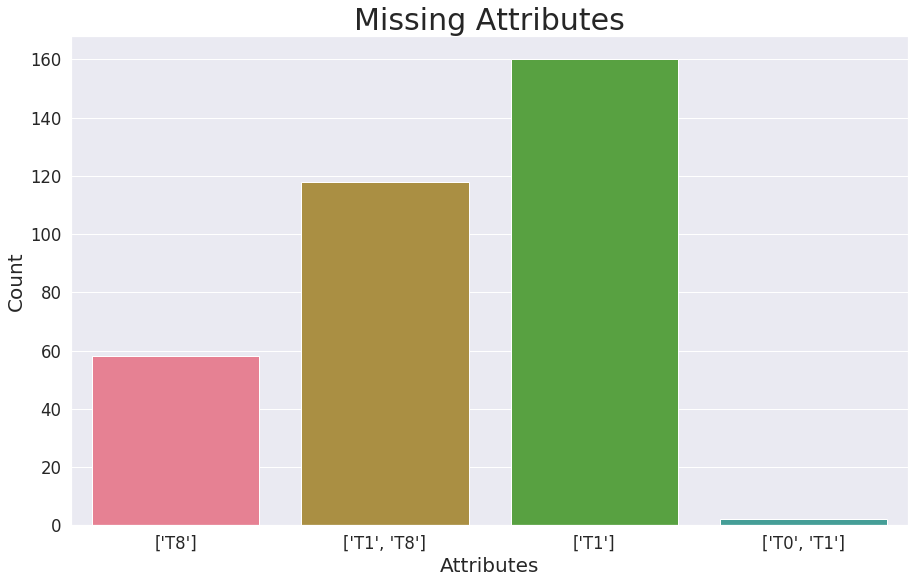

In [65]:
# Configure plot style 
sns.set(style='darkgrid', palette='husl', font_scale=1.5)
plt.figure(figsize=(15,9))

# Create the plot
g = sns.countplot(x='attributes', data=diff_by_row)

# Fine Tuning font size
g.set_xlabel('Attributes', fontsize=20)
g.set_ylabel('Count', fontsize=20)
g.axes.set_title('Missing Attributes', fontsize=30)

# Display
plt.show(g)

# Save File
fig = g.get_figure()
fig.savefig('./Images/{}.png'.format('missing_attributes'))

In [69]:
def homophiliy_test_adamic_adar(test_set, grph):
    '''Calculate then adamic/adar similarity of neighbors and return the most similar
    node and the similarity score
    
    :params test_set: target nodes we want to find the most similar neighbor for
    :type test_set: list of str
    :params grph: network containing target nodes
    :type grph: networkx.classes.graph.Graph
    :returns: each nodes most similar neighboring node and their similarity scores
    :rtype: dict of {str : (str, float)}
    '''
    
    # Store results
    sim_results = {}
    
    for i in test_set:
        nearest_neighbors = list(grph.neighbors(i))
        # Make sure that node has neighbors
        if nearest_neighbors:
            # If a node only has only 1 neighbor, inherit that neighbors attributes 
            if len(nearest_neighbors) == 1: 
                sim_results[i] = (nearest_neighbors[0], 0)
            else:
                # Generate node-neighbor pairings 
                node_pairs = [(i, j) for j in nearest_neighbors]
                preds = nx.adamic_adar_index(grph, ebunch=node_pairs)

                # Sort by similarity score
                preds = list(preds)
                preds.sort(key=lambda x: x[2], reverse=True)

                # Take the node with highest sim score
                sim_results[i] = (preds[0][1], preds[0][2])
        else:
            sim_results[i] = 0

    return sim_results

In [70]:
# Calculate the adamic/adar similarity on nodes in the subgraph
sim_results = homophiliy_test_adamic_adar(list(small_graph.nodes), small_graph)                     

In [71]:
# Create pandas dataframe  with node, most similar node, and similarity score
homophily_test = pd.DataFrame({
                        'n': list(sim_results.keys()),
                        'v': [i[0] if i != 0 else i for i in sim_results.values()], 
                        'sim_score': [i[1] if i != 0 else i for i in list(sim_results.values())],
                        })

In [72]:
homophily_test.head()

,n,v,sim_score
0,1648311,6334893,8.568901
1,6038742,6334893,1.565508
2,4376857,6334893,7.295359
3,3717094,6334893,1.018333
4,1301697,6334893,0.000000


In [73]:
# Convert 'n' and 'v' columns to int64 to match trainset 
homophily_test[['n','v']] = homophily_test[['n','v']].astype(np.int64)
# Check
type(homophily_test['n'][0])

numpy.int64

In [74]:
# Merge homphily_test dataframe with corresponding attributes to see if they overlap 
homophily_test = homophily_test.merge(train_set, left_on='n', right_on='id', how='left')
homophily_test = homophily_test.merge(train_set, left_on='v', right_on='id', how='left')
# Check results
homophily_test.head()

,n,v,sim_score,id_x,attr_x,id_y,attr_y
0,1648311,6334893,8.568901,1648311.0,T0:0 T1:1,6334893,T0:0 T1:1
1,6038742,6334893,1.565508,6038742.0,T0:0 T1:1968,6334893,T0:0 T1:1
2,4376857,6334893,7.295359,4376857.0,T0:0 T1:437,6334893,T0:0 T1:1
3,3717094,6334893,1.018333,3717094.0,T0:0 T1:1,6334893,T0:0 T1:1
4,1301697,6334893,0.000000,1301697.0,T0:0 T1:1317,6334893,T0:0 T1:1


In [75]:
# Drop uneeded columns and rename 
homophily_test.drop(['id_x', 'id_y'], inplace=True, axis=1)
homophily_test.columns = ['n', 'v', 'sim_score', 'attr_n', 'attr_v']
# Check
homophily_test.head()

,n,v,sim_score,attr_n,attr_v
0,1648311,6334893,8.568901,T0:0 T1:1,T0:0 T1:1
1,6038742,6334893,1.565508,T0:0 T1:1968,T0:0 T1:1
2,4376857,6334893,7.295359,T0:0 T1:437,T0:0 T1:1
3,3717094,6334893,1.018333,T0:0 T1:1,T0:0 T1:1
4,1301697,6334893,0.000000,T0:0 T1:1317,T0:0 T1:1


In [76]:
# If attributes are equal, assign True, else False
homophily_test = homophily_test.assign(NE=homophily_test['attr_n'] == homophily_test['attr_v'])
# Check
homophily_test.head()

,n,v,sim_score,attr_n,attr_v,NE
0,1648311,6334893,8.568901,T0:0 T1:1,T0:0 T1:1,True
1,6038742,6334893,1.565508,T0:0 T1:1968,T0:0 T1:1,False
2,4376857,6334893,7.295359,T0:0 T1:437,T0:0 T1:1,False
3,3717094,6334893,1.018333,T0:0 T1:1,T0:0 T1:1,True
4,1301697,6334893,0.000000,T0:0 T1:1317,T0:0 T1:1,False


In [77]:
homophily_test['NE'].value_counts()

False    37
True     35
Name: NE, dtype: int64

In [78]:
diff_attr = homophily_test[homophily_test.NE == False].sim_score
same_attr = homophily_test[homophily_test.NE == True].sim_score

/Users/koki/Documents/Learning/UMICH_course_material/SI_671_Data_Mining/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


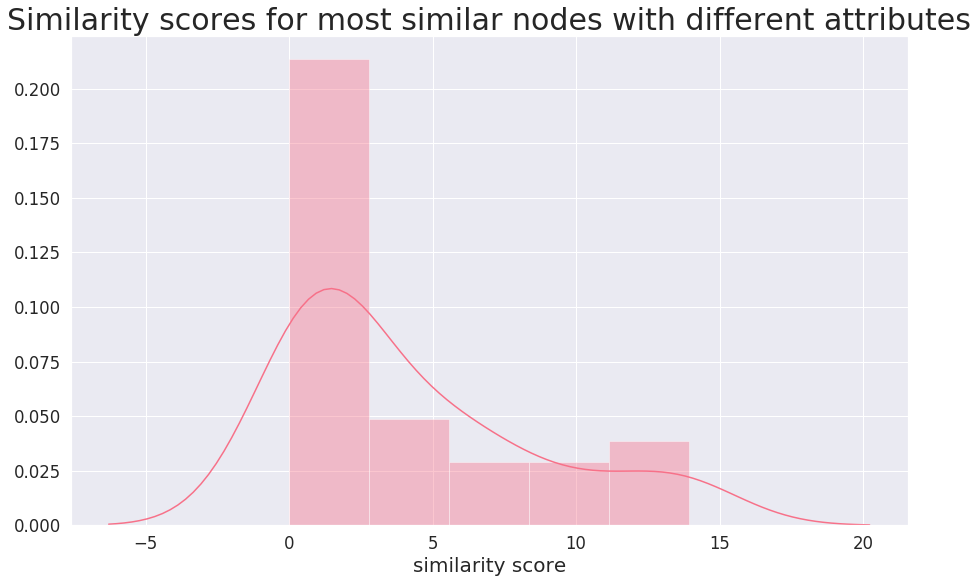

In [80]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Set the style of seaborn plot
sns.set(style='darkgrid', palette='husl', font_scale=1.5)

# Create matplotlib Figure and Axes object
f, ax = plt.subplots(figsize=(15,9))

# Create the plot
g = sns.distplot(diff_attr.tolist())

# Fine Tuning font size
g.set_xlabel('similarity score', fontsize=20)
# g.set_ylabel('Number of Nodes', fontsize=20)
g.axes.set_title('Similarity scores for most similar nodes with different attributes', fontsize=30)

# Display
plt.show(g)

# Save File
fig = g.get_figure()
fig.savefig('./Images/{}.png'.format('ave_degree_distribution_diff_attributes'))

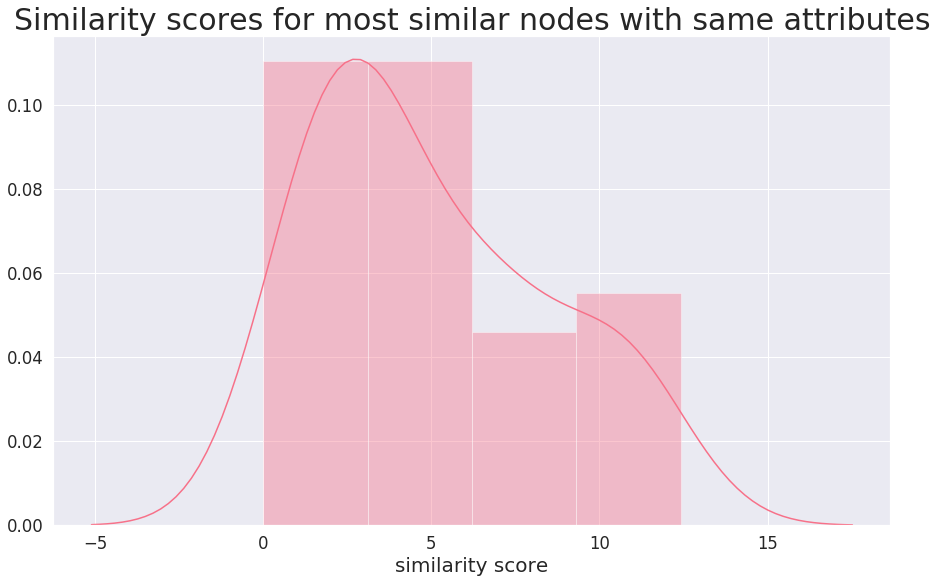

In [81]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Set the style of seaborn plot
sns.set(style='darkgrid', palette='husl', font_scale=1.5)

# Create matplotlib Figure and Axes object
f, ax = plt.subplots(figsize=(15,9))

# Create the plot
g = sns.distplot(same_attr .tolist())

# Fine Tuning font size
g.set_xlabel('similarity score', fontsize=20)
# g.set_ylabel('Number of Nodes', fontsize=20)
g.axes.set_title('Similarity scores for most similar nodes with same attributes', fontsize=30)

# Display
plt.show(g)

# Save File
fig = g.get_figure()
fig.savefig('./Images/{}.png'.format('ave_degree_distribution_same_attributes'))

In [83]:
# Nodes with same attributes 
homophily_test[homophily_test.NE == True].sort_values('sim_score', ascending=False)[:10]

,n,v,sim_score,attr_n,attr_v,NE
19,5000153,6334893,12.416429,T0:0 T1:1,T0:0 T1:1,True
45,3848051,6334893,11.058141,T0:0 T1:1,T0:0 T1:1,True
21,163000,6334893,10.972290,T0:0 T1:1,T0:0 T1:1,True
14,5261893,6334893,10.589795,T0:0 T1:1,T0:0 T1:1,True
71,6004908,6334893,10.517759,T0:0 T1:1,T0:0 T1:1,True
18,4923461,6334893,9.869773,T0:0 T1:1,T0:0 T1:1,True
0,1648311,6334893,8.568901,T0:0 T1:1,T0:0 T1:1,True
23,3171504,6334893,8.342964,T0:0 T1:1,T0:0 T1:1,True
38,1227055,6334893,7.403613,T0:0 T1:1,T0:0 T1:1,True
17,4283216,6334893,7.335364,T0:0 T1:1,T0:0 T1:1,True


In [84]:
# Nodes with different attributes
homophily_test[homophily_test.NE == False].sort_values('sim_score', ascending=False)[:10]

,n,v,sim_score,attr_n,attr_v,NE
32,6579303,6334893,13.934050,T0:0 T1:60 T8:0,T0:0 T1:1,False
42,6334893,6579303,13.934050,T0:0 T1:1,T0:0 T1:60 T8:0,False
51,1950058,6334893,13.779261,T0:0 T1:1 T8:2,T0:0 T1:1,False
8,1992159,6334893,12.495889,T0:0 T1:1134,T0:0 T1:1,False
66,2551705,6334893,10.982267,T0:0 T1:1 T8:1,T0:0 T1:1,False
61,616018,6334893,9.542297,T0:0 T1:1 T8:2,T0:0 T1:1,False
65,3673845,6334893,8.638870,T0:0 T1:505 T8:3,T0:0 T1:1,False
2,4376857,6334893,7.295359,T0:0 T1:437,T0:0 T1:1,False
47,6489403,6334893,7.142203,T0:0 T1:182,T0:0 T1:1,False
29,2019089,6334893,5.951823,T0:0 T1:92,T0:0 T1:1,False


For the particular dataset, homophily does not appear to hold well. Again, homophily in a social context explains that people who share similarities in socially significant ways are more likely to be linked. A subgraph of the original graph was created using the neighboring nodes of a randomly selected node. For each node in the subgraph, we calculated the similarity scores with its neighbors (if any), and returned the highest similarity score which was plotted on a histogram. It appears that most of the similarity scores were on the lower end (right-skewed) except a few with high similarity scores, and most nodes did not share the same attributes as only 11 of 71 nodes did. Of nodes with matching attributes, it seems the majority had low similarity scores as well (right-skewed). 

# Future Approaches 

For the next steps, I would like to revise my current approach for attribute predictions and see how the algorithm can be improved by taking into account attribute trends. From observing the data, I realized that out of the three classes of attributes (T0, T1, and T8), T0 and T1 were far more prevalent than T8. Perhaps, in real life social network, T0 and T1 are attributes much more common among users, whereas T8 is rarer and much more specific. For example, in LinkedIn, T0 could be a user’s educational background which, whereas T8 could be a professional certification a user has obtained. On a business professional network, ones educational background is a common attribute included in many profiles, but much fewer individuals may have certifications listed, such as being certified doctor, lifeguard, lawyer, etc. 
 
For more common classes of attributes (T0, T1), I could develop an algorithm that counts and assigns the most common attribute shared among all nearest neighbors. For example, in a given scenario, if T0:1 was more common than T0:2 out of all nearest neighbors, then inherit T0:1. 

For rarer classes of attributes (T8), I would use my current method of inheriting the attribute of the most similar neighbor as calculated by the Adamic/Adar algorithm. In cases where multiple nodes have the same similarity score and also have different variations of the rare attribute, I could either select the winning attribute randomly or by frequency (e.g., T8:213 might be more common than T8:121, so inherit T8:213).

Additionally, I would like to explore other algorithms, such as treating attributes as itemsets which can be used to build association rules (e.g, If T0:12 and T1:334 are present, then T8:123 is also likely to be present).